# Retention Insert Scores Fallback
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [35]:
import boto3
import getpass
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import awswrangler as wr
import warnings

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [36]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [88]:
lkupclientid = 5
dbname = 'stlrtrailblazers'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27466 entries, 0 to 27465
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            27466 non-null  int64  
 1   dimCustomerMasterId     27466 non-null  int64  
 2   customerNumber          27463 non-null  object 
 3   year                    27466 non-null  int64  
 4   productGrouping         27466 non-null  object 
 5   totalSpent              27466 non-null  float64
 6   recentDate              27466 non-null  object 
 7   attendancePercent       27466 non-null  float64
 8   renewedBeforeDays       27466 non-null  int64  
 9   isBuyer                 27466 non-null  object 
 10  source_tenure           27466 non-null  int64  
 11  tenure                  27466 non-null  int64  
 12  distToVenue             27466 non-null  float64
 13  totalGames              27466 non-null  int64  
 14  recency                 27466 non-null

### We should specify the features used in our model:

In [89]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18586, 11)
Unseen Data For Predictions: (3280, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [90]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [91]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7153,0.8276,0.6308,0.8908,0.7384,0.4454,0.4780,0.6000


### Let's load in our 2021 season data and get retention scores using the model:

In [92]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5600, 11)

In [93]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

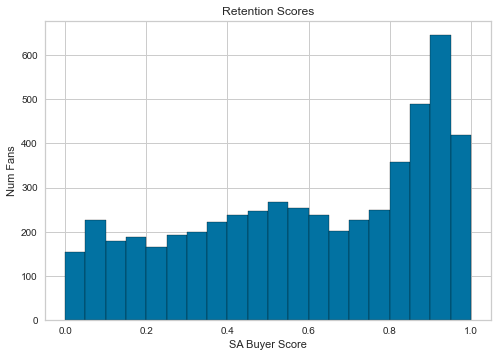

In [94]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [95]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]       420
(0.9, 0.95]       645
(0.85, 0.9]       491
(0.8, 0.85]       358
(0.75, 0.8]       250
(0.7, 0.75]       227
(0.65, 0.7]       202
(0.6, 0.65]       237
(0.55, 0.6]       254
(0.5, 0.55]       267
(0.45, 0.5]       246
(0.4, 0.45]       239
(0.35, 0.4]       223
(0.3, 0.35]       200
(0.25, 0.3]       192
(0.2, 0.25]       166
(0.15, 0.2]       188
(0.1, 0.15]       178
(0.05, 0.1]       227
(-0.001, 0.05]    153
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [45]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

BJSC-ZSRN
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [97]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname,
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

In [80]:
sql_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE currversnflag = 1
"""

df_recent_scores = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_recent_scores.shape[0]}")

TOTAL RECORDS: 0


### Insert the new scores into the customerRetentionScores table:

In [99]:
# create batches of dataframes based on batch size
batch_size = 250
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

In [ ]:
print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE:")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(1)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
    
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

### Now let's update the old scores to currVersFlag = 0

In [68]:
print(f"UPDATING {len(df_recent_scores)} OLD RETENTION SCORES IN DATABASE:")

df_recent_scores['currversnflag'] = False
ids = ', '.join(map(str, list(df_recent_scores['customerretentionscoreid'])))

update_statement = f"""
    UPDATE {dbname}.dw.customerretentionscores
    SET currversnflag = 0
    WHERE lkupclientid = {lkupclientid}
    AND customerretentionscoreid IN ({ids})
"""

wr.data_api.redshift.read_sql_query(
    sql = update_statement, 
    con = conn
)

print(f"UPDATED {len(df_recent_scores)} SUCCESSFULLY")

UPDATING 4504 OLD RETENTION SCORES IN DATABASE:
UPDATED 4504 SUCCESSFULLY


### Let's query RedShift to make sure our records got into the database:

In [ ]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

df_current_scores = df_scores[df_scores['currversnflag'] == 'true']

print(f"TOTAL RECORDS: {df_current_scores.shape[0]}")
df_scores['currversnflag'].value_counts()

### We can also use the API to delete records from the database:

In [98]:
delete_statement = f"""
    DELETE 
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

wr.data_api.redshift.read_sql_query(
    sql = delete_statement, 
    con = conn
)

print(f"DELETED ALL RECORDS SUCCESSFULLY")

DELETED ALL RECORDS SUCCESSFULLY
